<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Train_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ResNet-101 on Imgs-Hateful-Memes(train+test_unseen)

In [2]:
# !gdown https://drive.google.com/uc?id=14u9sgibcvl5-2oThkjYWlgYPvgjp0RhV

Downloading...
From: https://drive.google.com/uc?id=14u9sgibcvl5-2oThkjYWlgYPvgjp0RhV
To: /content/imgs-train+test.zip
100% 1.36G/1.36G [00:31<00:00, 43.2MB/s]


In [ ]:
# !unzip /content/imgs-train+test.zip

In [4]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Loading Training Dataset and Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    # def __getitem__(self, index):
    #     while True:
    #         try:
    #             image, label = self.dataset[index]
    #             return image, label
    #         except (UnidentifiedImageError, FileNotFoundError) as e:
    #             print(f"Error loading image at index {index}: {e}")
    #             index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [8]:
data_dir = "/content/img-train+test/train"
dataset = TrainingDataset(data_dir)

In [9]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 9500
Number of classes: 2


In [10]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Validation Data Loader

In [11]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [12]:
valPath = "/content/img-train+test/test"
val_dataset = ValidationDataset(valPath)

In [13]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


# EDA

In [15]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [16]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [18]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 2
Total sum: 9500
dict_values([5960, 3540])


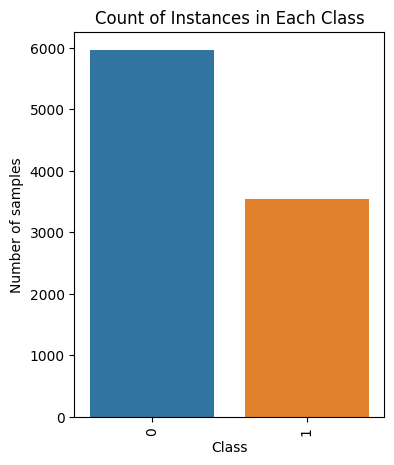

In [19]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(4, 5))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

# Loading ResNet-101

In [20]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 2


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

In [23]:
training_loss = []

for epoch in range(num_epochs):
    # Set the model to training mode
    resnet.train()
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print("Training Loss==========================>>")
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_loss:.4f}")

    resnet.eval()
    predicted_classes = []
    actual_labels = []
    with torch.no_grad():
        for images, labels in validation_data_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet(images)

            # Get the predicted labels
            _, predicted_label = torch.max(outputs, 1)

            # Store the predicted and true labels
            predicted_classes.extend(predicted_label.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predicted_classes)
    precision = precision_score(actual_labels, predicted_classes, average='weighted')
    recall = recall_score(actual_labels, predicted_classes, average='weighted')
    f1 = f1_score(actual_labels, predicted_classes, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print(classification_report(actual_labels, predicted_classes))
    print("Confusion Matrix: ")
    cm = confusion_matrix(actual_labels, predicted_classes)
    print(cm)
    auroc = roc_auc_score(actual_labels, predicted_classes)
    print("AUROC:", auroc)

    save_dir = "/content/Model/Models-Train-07/"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    model_name = str(epoch+1) + "_model.pth"
    save_path = os.path.join(save_dir, model_name)  # Specify the complete path to the model file
    torch.save(resnet.state_dict(), save_path)

Training Loss==========================>>
Epoch 1/20 Training Loss: 0.6645
Accuracy: 0.6215
Precision: 0.5848148738230461
Recall: 0.6215
F1-score: 0.5648776363937891
              precision    recall  f1-score   support

           0       0.64      0.89      0.75      1250
           1       0.49      0.18      0.26       750

    accuracy                           0.62      2000
   macro avg       0.57      0.53      0.50      2000
weighted avg       0.58      0.62      0.56      2000

Confusion Matrix: 
[[1107  143]
 [ 614  136]]
AUROC: 0.5334666666666666
Training Loss==========================>>
Epoch 2/20 Training Loss: 0.5958
Accuracy: 0.6665
Precision: 0.65226781415306
Recall: 0.6665
F1-score: 0.6398184623154083
              precision    recall  f1-score   support

           0       0.69      0.86      0.76      1250
           1       0.60      0.34      0.43       750

    accuracy                           0.67      2000
   macro avg       0.64      0.60      0.60      2000

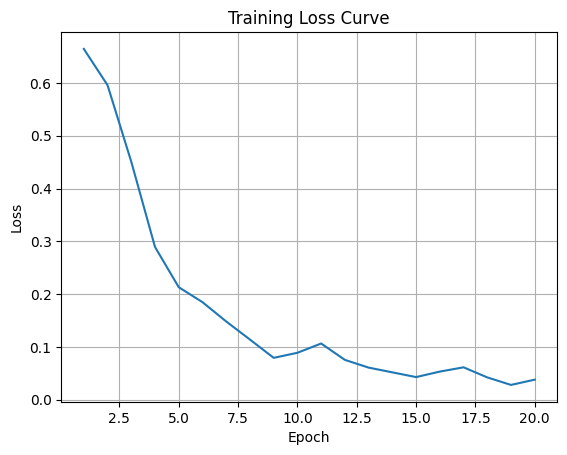

In [24]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Model

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
# %cd /content/Model/Models-Train-07/

In [27]:
# !cp 21_model.pth /content/drive/MyDrive/21_model.pth